In [1]:
import numpy as np
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

In [2]:
# %matplotlib notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [31]:
# Create the machine, which specifies coil locations
# and equilibrium, specifying the domain to solve over
# this has to be either
# freegs.machine.MASTU(), in which case:
#tokamak = freegs.machine.MASTU()
# or
# MASTU_coils.MASTU_wpass()
from freegsnke import MASTU_coils
tokamak = MASTU_coils.MASTU_wpass()


# Creates equilibrium object and initializes it with 
# a "good" solution
plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed in principle, 
                        #in practice domains as below are used to detect
                        #plasma hitting the wall during evolution
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-2.2, Zmax=2.2,   # Height range
                        #grid resolution can be changed
                        nx=129, ny=129, # Number of grid points
                        psi=plasma_psi)  
                        # nx=65, ny=65, # Number of grid points
                        # psi=plasma_psi[::2,::2])     
                        # nx=65, ny=129, # Number of grid points
                        # psi=plasma_psi[::2,:])     

# Sets desired plasma properties for the 'starting equilibrium'
# values can be changed
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(8.1e3, # Plasma pressure on axis [Pascals]
                            6.2e5, # Plasma current [Amps]
                            0.5, # vacuum f = R*Bt
                            alpha_m = 1.0,
                            alpha_n = 2.0)


# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.4   # Outboard midplane
Rin = 0.4  # Inboard midplane

xpoints = [(Rx, -Zx),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
    #if geometry is changed considerably, it can be useful to  
    #start by imposing this first set of constraints only
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
    
           
    #then adding all of the following
           (Rx,-Zx, 1, -0.9),
           (Rx,-Zx, Rmid, -0.4),   # Outboard midplane, lower X-point
           (Rx,Zx, Rmid, +0.4),   # Outboard midplane, upper X-point
           (Rx,Zx, 1, +0.9),
           
           

           # Link inner and outer midplane locations
           (Rx, Zx, .5, 1.25),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx, -Zx, .5, -1.25),

#       # Separatrix in the divertor chamber
           (Rx,-Zx, 0.6, -1.45),
           (Rx, Zx, 0.6,  1.45),
           
           (Rx,-Zx, 0.68, -1.55),
           (Rx, Zx, 0.68,  1.55),
           
           (Rx,-Zx, 0.8, -1.7),
           (Rx, Zx, 0.8,  1.7),
           
         #   (Rx,-Zx, 0.9, -1.75),
         #   (Rx, Zx, 0.9,  1.75),
           
            # (Rx,-Zx, 1., -1.8),
            # (Rx, Zx, 1.,  1.8),
           
            # (Rx,-Zx, 1.3, -1.8),
            # (Rx, Zx, 1.3,  1.8),

            # (Rx,-Zx, 1.15, -1.8),
            # (Rx, Zx, 1.15,  1.8),

            # (Rx,-Zx, 1.5, -1.8),
            # (Rx, Zx, 1.5,  1.8),

            # (Rx,-Zx, 1.7, -1.8),
            # (Rx, Zx, 1.7,  1.8),

         #   (Rx,-Zx, 1.5, -1.85),
         #   (Rx, Zx, 1.5,  1.85),

         #   (Rx,-Zx, 1.6, -1.85),
         #   (Rx, Zx, 1.6,  1.85),

         #   (Rx,-Zx, 1.7, -1.85),
         #   (Rx, Zx, 1.7,  1.85),

         #   (Rx,-Zx, 1.8, -1.85),
         #   (Rx, Zx, 1.8,  1.85),

          
           
           
        # infra-coils separatrix
           (Rx,-Zx, .35, -1.3),
           (Rx, Zx, .35,  1.3),
           
       #     (Rx,-Zx, .5, -1.8),
       #     (Rx, Zx, .5,  1.8),
           
       #     (Rx,-Zx, .6, -1.9),
       #     (Rx, Zx, .6,  1.9),
    
        #    (Rx,-Zx, .7, -2.2),
        #    (Rx, Zx, .7,  2.2),
           ]

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)
                                    
from freegsnke import newtonkrylov
NK = newtonkrylov.NewtonKrylov(eq)

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

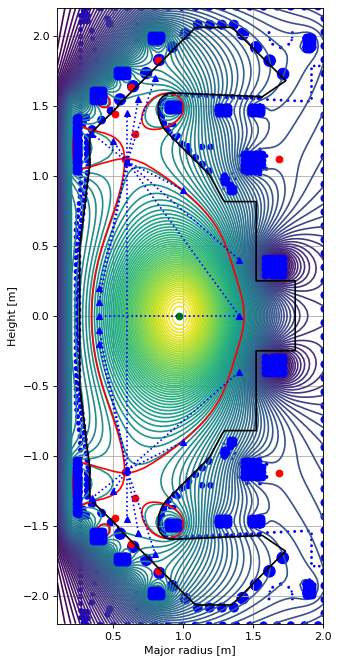

In [32]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)               
eq.tokamak['Solenoid'].current = 40000
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)  
NK.solve(eq, profiles, rel_convergence=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

In [33]:
# Initialize the evolution object
# This uses the starting equilibrium to get all the geometric constraints/grids etc
from freegsnke import nonlinear_solve
stepping = nonlinear_solve.nl_solver(profiles=profiles, eq=eq, 
                                        max_mode_frequency=10**2.4, 
                                        full_timestep=1e-4, 
                                        plasma_norm_factor=1500,
                                        plasma_resistivity=1e-6)
# this is the number of independent vessel normal modes (maximum is 699)
print('Input max_mode_frequency corresponds to ', 
       stepping.n_metal_modes, ' independent vessel normal modes')


# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils]

Input max_mode_frequency corresponds to  119  independent vessel normal modes


In [34]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.initialize_from_ICs(eq, profiles)

history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
shapes = stepping.shapes(stepping.eq1, stepping.profiles1)
history_width = [shapes[0]]
history_o_points = shapes[1]
history_elongation = [shapes[2]]

counter = 0
max_count = 125
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t}')
    display(f'current time step dt = {stepping.dt_step}')
    
    t_start = time.time()
    flag = stepping.nl_step_iterative(active_voltage_vec=U_active, 
                                       alpha=.85, 
                                       rtol_NK=1e-4,
                                       atol_increments=1e-3,
                                       rtol_residuals=1e-3,
                                       verbose=True,
                                       threshold=.01)
    t_end = time.time()
    t_per_step.append(t_end-t_start)

    t += stepping.dt_step
    history_times.append(t)
    shapes = stepping.shapes(stepping.eq2, stepping.profiles2)

    history_currents.append(stepping.currents_vec)
    history_equilibria.append(deepcopy(stepping.eq2))
    history_width.append(shapes[0])
    history_o_points = np.append(history_o_points,shapes[1], axis=0)
    history_elongation.append(shapes[2])

    counter += 1

history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)

'Step: 124/124'

'current time t = 0.01239999999999998'

'current time step dt = 0.0001'

0.027416940218320064 1841.954293754223 63932.135153978474
0.0005306190922175429 0.005784172706985552
0.008105882958660477 805.0042665876074 34009.4899470931
0.000548024175661984 0.006419838203955967
0.01376313363978738 719.7950188088379 19022.836926547036
0.000540603325014834 0.006823085716581362
0.0029959464882753366 1492.276978562419 84118.44532416812
0.0004658930511116699 0.005341031502040853
0.004205060576951753 1270.8912857466407 77919.10105758793
0.0005609949712058634 0.006460439571099808
0.001644201788600286 1152.1037698351768 66988.90615955715
0.000542722844711176 0.006262323340740231
0.0011026696862779138 1557.6886065005326 81505.90396269767
0.0005486475054443826 0.006354803630579553
0.004336794094353763 1190.92995571268 71434.70575380097
0.0008979058912323552 0.00991293109206369
0.0011745213438822913 1134.6632399993812 64498.098093141285
0.0008267334622636073 0.009508127504011823
0.0007280235234784183 1050.3081233089122 59610.41473207511
0.0008631846437507326 0.00995116779748

KeyboardInterrupt: 

In [39]:
# stepping.assign_currents(currents_vec=stepping.currents_vec, eq=stepping.eq1, profile=stepping.profiles1)
eq_p = deepcopy(stepping.eq1)
profiles_p = deepcopy(stepping.profiles1)
dJ_p = stepping.dJ

In [ ]:
plt.imshow(stepping.re)

In [ ]:
stepping.assign_currents(currents_vec=stepping.currents_vec, eq=stepping.eq1, profile=stepping.profiles1)

In [10]:
NK.solve(eq=stepping.eq1, profiles=stepping.profiles1, rel_convergence=1e-8)

In [40]:
stepping.nl_step_iterative(active_voltage_vec=U_active, 
                                       alpha=.85, 
                                       rtol_NK=1e-4,
                                       atol_increments=1e-3,
                                       rtol_residuals=1e-3,
                                       verbose=True,
                                       threshold=.01)

2.975252021362029e-05 249.39108028046763 13588.43630604406
0.0014656095005142129 0.017303520301855668
2.8348103904509874e-05 246.48135905856398 13429.8959078405
0.0015018805551219358 0.017731749603304425
2.7032942086297307e-05 243.70662926945954 13278.71071432155
0.0015390492485450394 0.018170576756131263
2.5799692327381098e-05 241.05848327048074 13134.422622972806
0.001577137796495052 0.018620264046869228
2.464175252649463e-05 238.52919107289856 12996.61045408161
0.001616168963145688 0.019081080237519088
2.3553173400290264e-05 236.1116333265607 12864.886299316913
0.0016561660773948292 0.019553300758183068
2.2528582537898865e-05 233.79924212340484 12738.892296804215
0.001697153043288615 0.020037207827656944
2.1563118050162405e-05 231.58594859224704 12618.297775275823
0.0017391543579519046 0.02053309066910647
2.065237196674262e-05 229.4661363031251 12502.796715318027
0.0017821951246894602 0.021041245660973318
1.9792339961318133e-05 227.43459984537202 12392.105492544306
0.001826301069971

KeyboardInterrupt: 

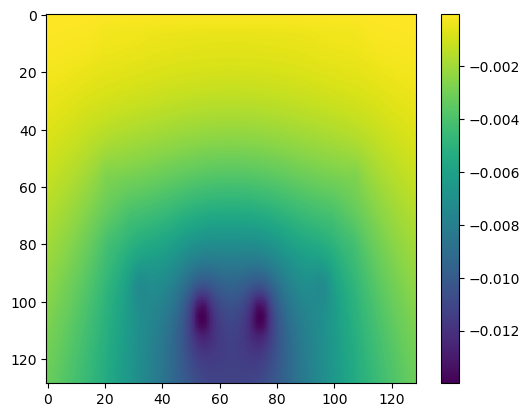

In [35]:
plt.imshow(eq_p.tokamak.calcPsiFromGreens(pgreen=eq_p._pgreen) - stepping.eq2.tokamak.calcPsiFromGreens(pgreen=stepping.eq2._pgreen))
plt.colorbar()

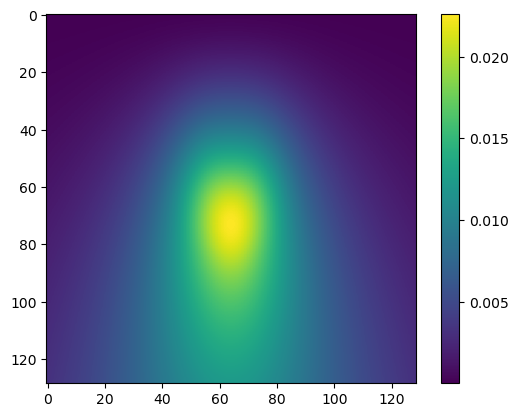

In [38]:
plt.imshow(eq_p.plasma_psi - stepping.eq2.plasma_psi)
plt.colorbar()

In [16]:
stepping.initialize_from_ICs(stepping.eq1, stepping.profiles1, rtol_NK=1e-4, reset_dJ=False)

NK will likely fail


In [ ]:
plt.imshow(stepping.eq2.plasma)

In [23]:
stepping.dJ += np.mean(stepping.dJ)*np.random.normal(size=len(stepping.dJ))

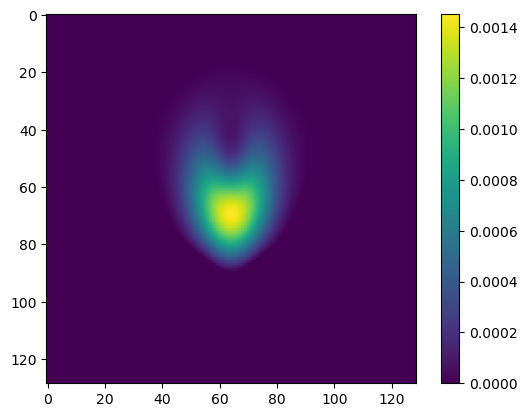

In [30]:
plt.imshow(stepping.rebuild_grid_map(stepping.dJ))
plt.colorbar()

In [32]:
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)

0

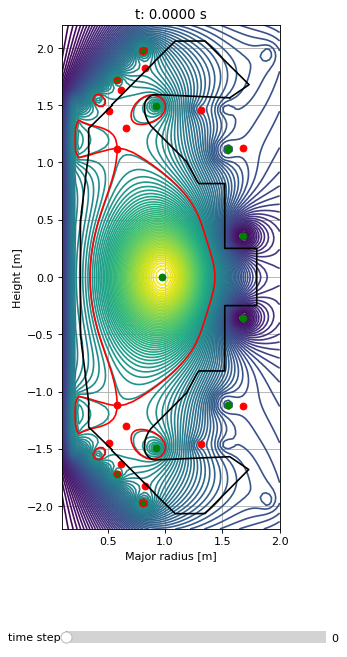

In [33]:
# Equilibrium evolution
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.grid(True)
fig.subplots_adjust(bottom=0.25)
history_equilibria[0].plot(axis=ax, show=False)
ax.set_title(f't: {history_times[0]:.4f} s')

ax_i = fig.add_axes([0.25, 0.1, 0.65, 0.03])
i = np.arange(0, len(history_equilibria))
s = Slider(ax_i, "time step", 0, i[-1], valinit=0, valstep=i)
def update(val):
    ax.clear()
    ax.grid(True)
    i = s.val
    history_equilibria[i].plot(axis=ax, show=False)
    ax.set_title(f't: {history_times[i]:.4f} s')
    fig.canvas.draw_dile()
s.on_changed(update)

Text(0, 0.5, 'Plasma elongation')

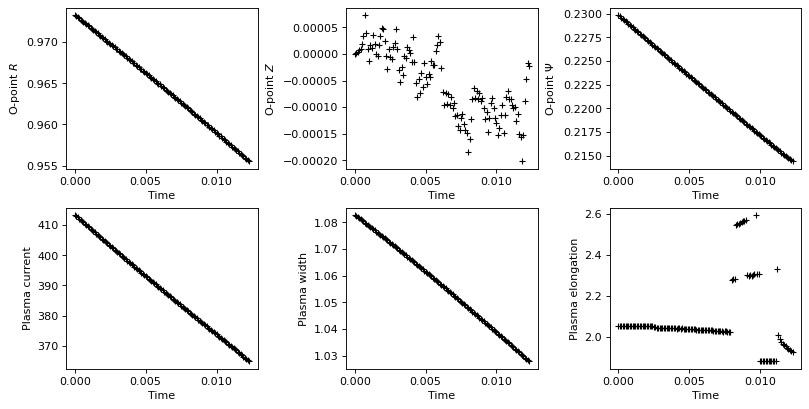

In [34]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1],'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

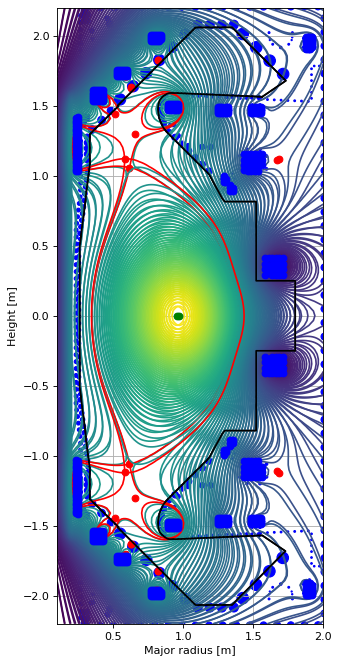

In [49]:
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
stepping.eq2.plot(axis=ax,show=False);
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);

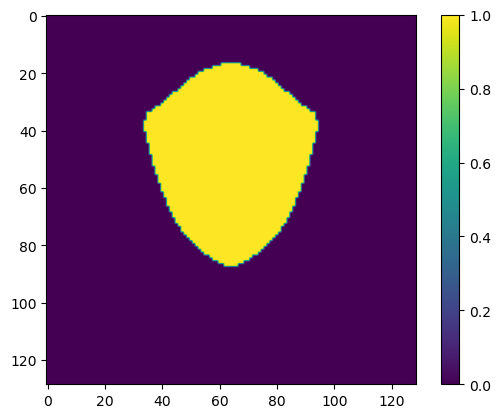

In [72]:
plt.imshow((stepping.profiles1.jtor>0) + (stepping.profiles2.jtor>0))
plt.colorbar()

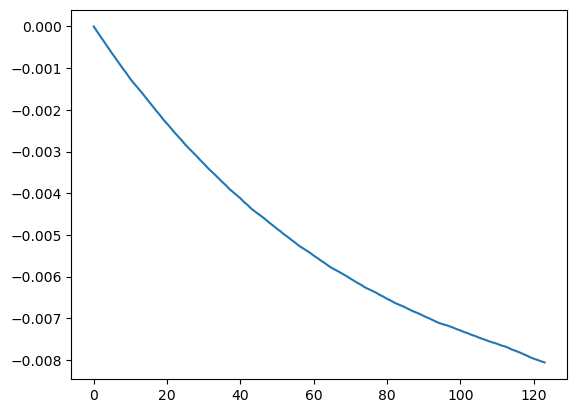

In [71]:
plt.plot((history_currents - history_currents[0])[:,109])